In [1]:
from LoopStructural import GeologicalModel
from LoopStructural.visualisation import LavaVuModelViewer

from LoopStructural.modelling.fault.fault_function import CubicFunction, FaultDisplacement, Ones, Composite
from LoopStructural.modelling.fault.fault_function_feature import FaultDisplacementFeature

from LoopStructural.datasets import value_headers, strike_dip_headers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import os
output='eliptical'
if not os.path.exists(output):
    os.mkdir(output)
bb = np.array([[0,0,0],
               [10,10,10]])
fault_value_data = pd.DataFrame([[5,5,9,0,0],
                                 [5,5,5,0,1],
#                                  [7,7,7,1,1],
                                 [5,0,5,0,2],
                                 [5,10,5,1,2],
                                ],
                                columns=value_headers()+['coord'])
fault_value_data['type'] = 'fault'
fault_strike_data = pd.DataFrame([[5,5,5,0,45,0],
                                  [5,5,5,180,45,1],
                                 [5,5,5,90,90,2]],
                                columns=strike_dip_headers()+['coord'])
fault_strike_data['type'] = 'fault'
strati_data = pd.DataFrame([[5,5,5,0]],columns=value_headers())
strati_data['type'] = 'strati'
strati_strike = pd.DataFrame([[5,5,5,0,0]],columns=strike_dip_headers())
strati_strike['type'] = 'strati'

In [3]:
data = pd.concat([fault_strike_data,fault_value_data,strati_strike,strati_data],sort=False)

In [4]:
rotation = [76.60582733154297, -13.266486167907715, -176.5645294189453]

### Set up the model

In [5]:
model = GeologicalModel(bb[0,:],bb[1,:])
model.set_model_data(data)

hw = CubicFunction()
hw.add_cstr(0,1)
hw.add_grad(0,0)
hw.add_cstr(1,0)
# hw.add_cstr(1,1)

hw.add_grad(1,0)
hw.add_max(1)
fw =CubicFunction()
fw.add_cstr(0,-1)
fw.add_grad(0,0)
fw.add_cstr(-1,0)
fw.add_grad(-1,0)
fw.add_min(-1)
gyf = CubicFunction()
gyf.add_cstr(-1,0)
gyf.add_cstr(1,0)
gyf.add_cstr(-0.2,1)
gyf.add_cstr(0.2,1)
gyf.add_grad(0,0)
gyf.add_min(-1)
gyf.add_max(1)
gzf = CubicFunction()
gzf.add_cstr(-1,0)
gzf.add_cstr(1,0)
gzf.add_cstr(-0.2,1)
gzf.add_cstr(0.2,1)
gzf.add_grad(0,0)
gzf.add_min(-1)
gzf.add_max(1)
gxf = Composite(hw,fw)


fault_displacement = FaultDisplacement(gx=gxf,gy=gyf,gz=gzf,
                                      gxmin=-2,gxmax=2,
                                      gzmin=.5,gzmax=1.5,
                                       gymin=0,gymax=1.5)

fault = model.create_and_add_fault('fault',
                                   1,
                                   nelements=5000,
                                   interpolatortype='FDI',
                                   solver='lu',
                                   damp=True,
                                   faultfunction=fault_displacement,buffer=0.2)
strati = model.create_and_add_foliation('strati',
                                        nelements=5000,
                                        interpolatortype='FDI',
                                        solver='lu',
                                        damp=True,buffer=0.5)
f1_displacement_feature = FaultDisplacementFeature(fault['feature'].faultframe,fault_displacement)


### Fault displacement figure

In [6]:
fregion = lambda pos : f1_displacement_feature.evaluate_value(pos) > 0.01



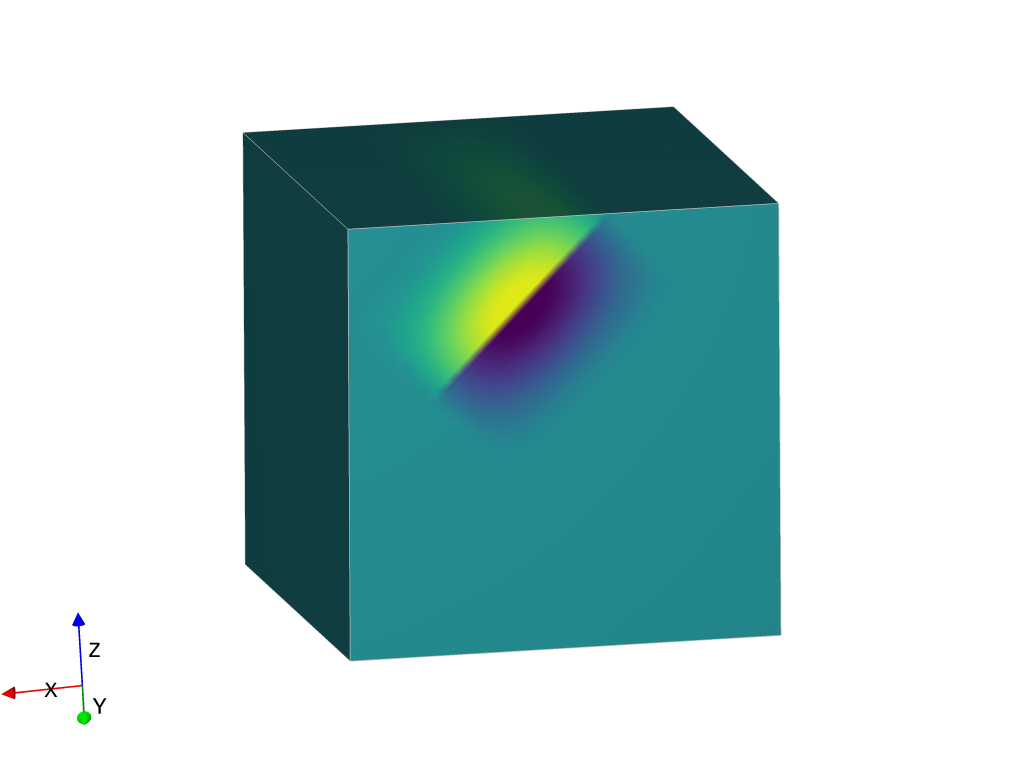

'eliptical/fault_displacement.png'

In [7]:
viewer = LavaVuModelViewer(model)

# f1_displacement_feature = FaultDisplacementFeature(fault['feature'].faultframe,fault_displacement)
viewer.add_scalar_field(f1_displacement_feature,cmap='viridis',vmin=-1,xmax=1)
# viewer.lv.rotatey(90)
viewer.lv.rotate(rotation)
viewer.lv.display()
viewer.lv.image(output+'/fault_displacement.png')

### Faulted stratigraphy figure


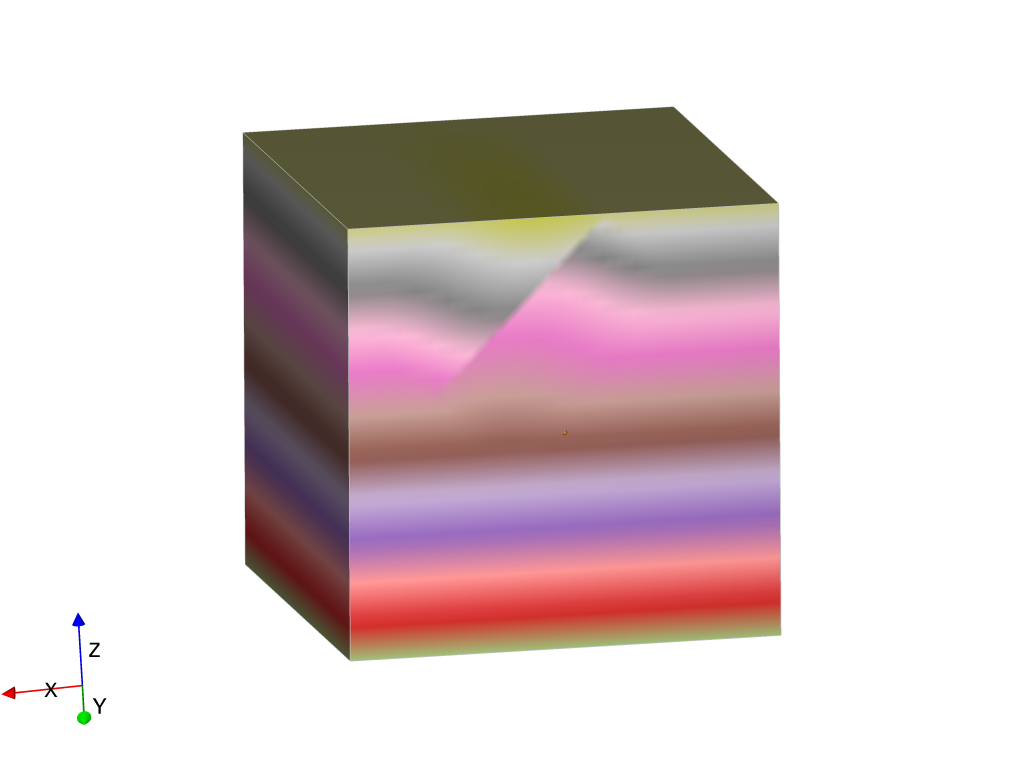

'eliptical/stratigraphy.png'

In [8]:
viewer = LavaVuModelViewer(model)
viewer.add_isosurface(fault['feature'],isovalue=0)
for i in range(3):
    viewer.add_data(fault['feature'][i])
# viewer.add_isosurface(fault['feature'][1],nslices=5)
# # viewer.add_isosurface(fault['feature'][2],nslices=5)
viewer.add_isosurface(strati['feature'],
                     nslices=5)
viewer.add_scalar_field(strati['feature'],cmap='tab20')
# viewer.add_scalar_field(f1_displacement_feature,cmap='rainbow')
viewer.lv.rotate(rotation)
viewer.lv.display()
viewer.lv.image(output+'/stratigraphy.png')
# viewer.interactive()

### Surfaces


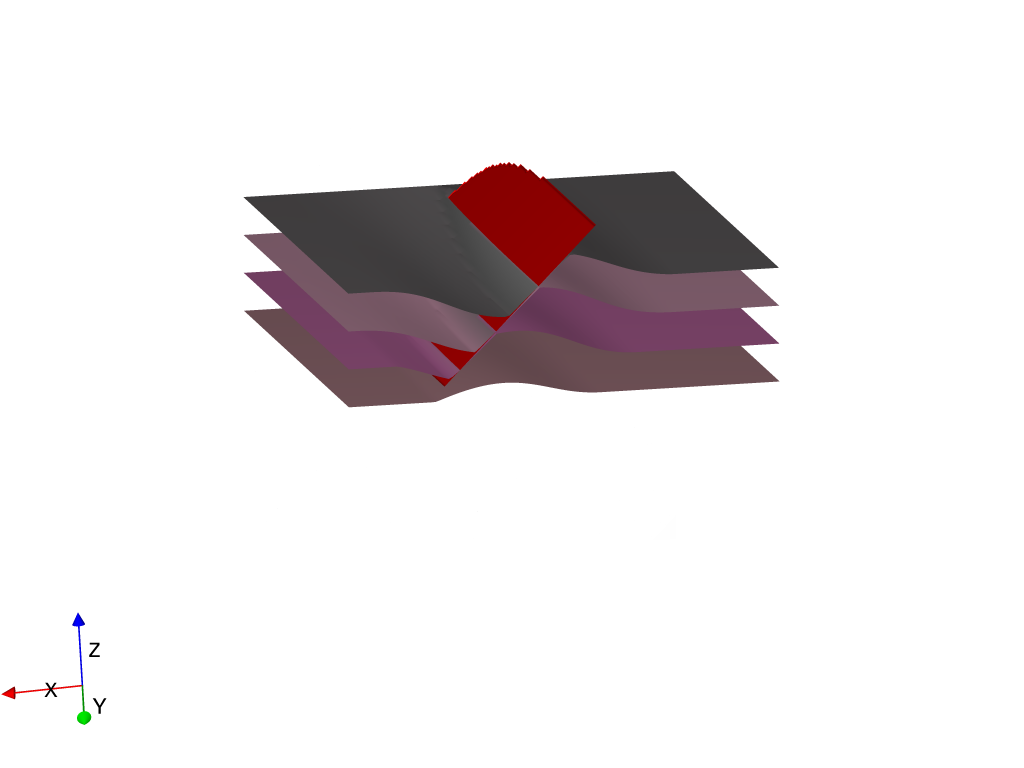

'eliptical/surfaces.png'

In [25]:
fregion = lambda pos : f1_displacement_feature.evaluate_on_surface(pos) > 0.2
viewer = LavaVuModelViewer(model)
viewer.nsteps = np.array([100,100,100])
viewer.add_section(None,axis='y',value=model.bounding_box[0,1],colour='white')
viewer.add_isosurface(fault['feature'],
                      isovalue=0,
                     region=fregion
                     )
# for i in range(3):
#     viewer.add_data(fault['feature'][i])
# viewer.add_isosurface(fault['feature'][1],nslices=5)
# # viewer.add_isosurface(fault['feature'][2],nslices=5)
viewer.add_isosurface(strati['feature'],
                      slices=[4,3,2,1],
#                      nslices=5,
                     paint_with=strati['feature'],
                      cmap='tab20'
                     )
# viewer.add_scalar_field(strati['feature'],cmap='tab20')
# viewer.add_scalar_field(f1_displacement_feature,cmap='rainbow')
viewer.lv.rotate(rotation)
viewer.lv['border'] = 0

viewer.lv.display()

viewer.lv.image(output+'/surfaces.png')
# viewer.interactive()

In [11]:
viewer.lv['xyzrotate']

[76.60581970214844, -13.266487121582031, -176.5645294189453]

### Fault frame 0


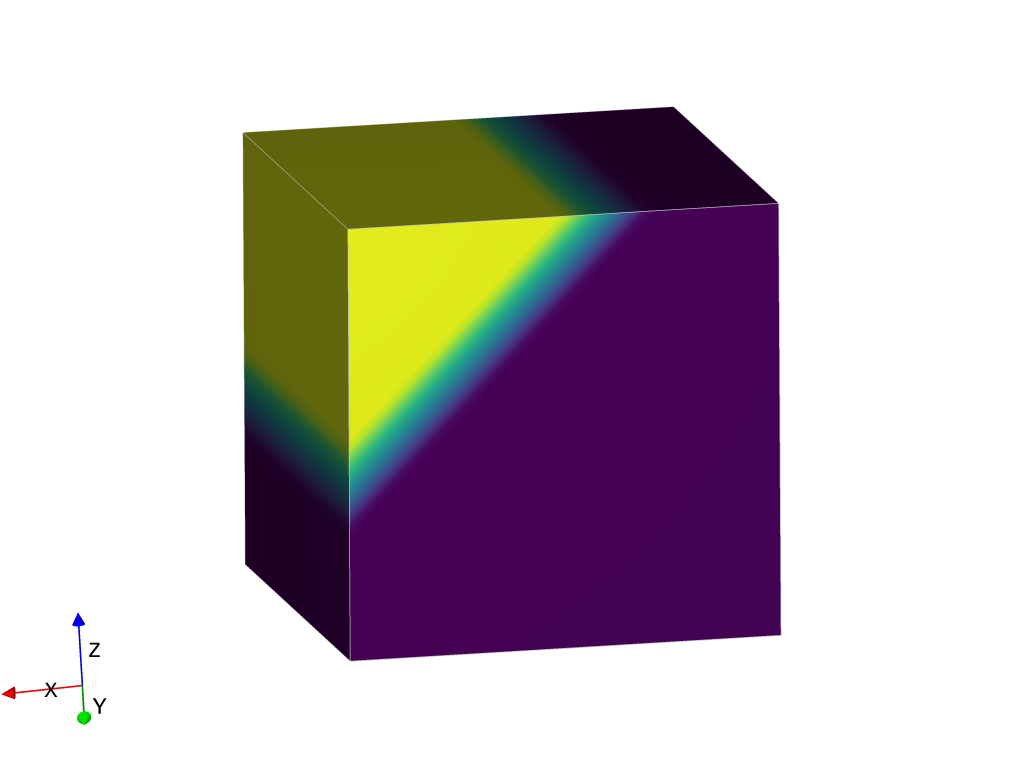

'f1_0.png'

In [12]:
viewer = LavaVuModelViewer(model)
# viewer.add_isosurface(fault['feature'],isovalue=0)
# for i in range(3):
#     viewer.add_data(fault['feature'][i])
# viewer.add_isosurface(fault['feature'][1],nslices=5)
# # viewer.add_isosurface(fault['feature'][2],nslices=5)
# viewer.add_isosurface(strati['feature'],
#                      nslices=5)
viewer.add_scalar_field(fault['feature'][0],cmap='viridis',vmin=-1,vmax=1)
# viewer.add_scalar_field(f1_displacement_feature,cmap='rainbow')
viewer.lv.rotate(rotation)
viewer.lv.display()
viewer.lv.image('f1_0.png')

### Fault frame 1


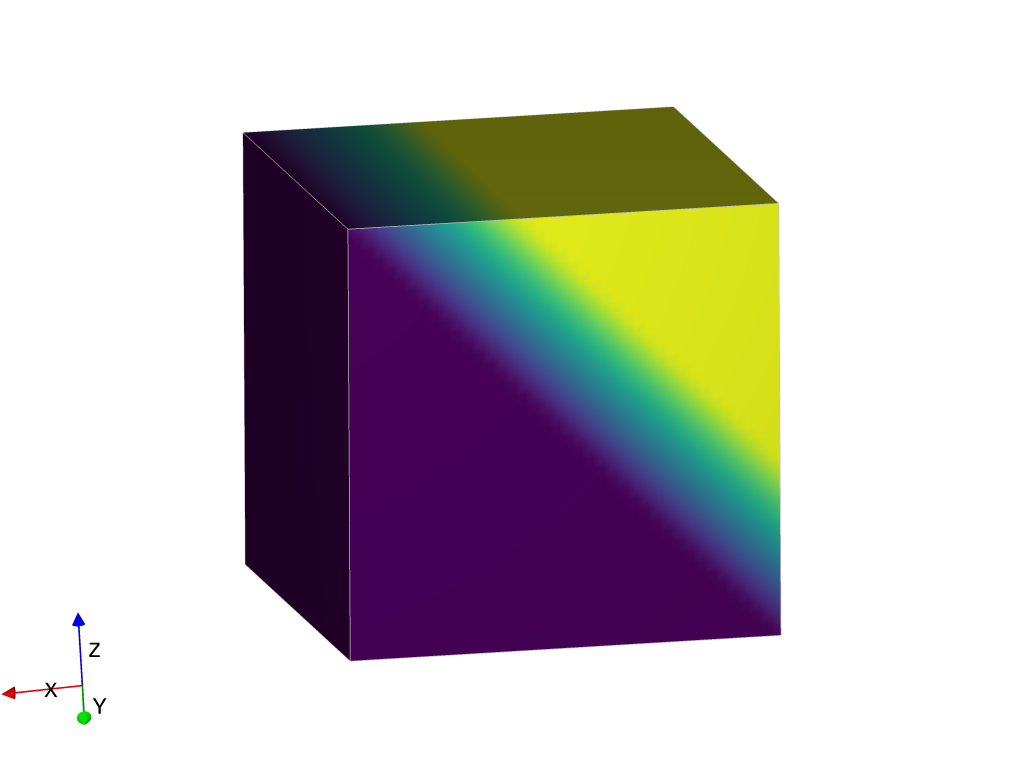

'f1_1.png'

In [13]:
viewer = LavaVuModelViewer(model)
# viewer.add_isosurface(fault['feature'],isovalue=0)
# for i in range(3):
#     viewer.add_data(fault['feature'][i])
# viewer.add_isosurface(fault['feature'][1],nslices=5)
# # viewer.add_isosurface(fault['feature'][2],nslices=5)
# viewer.add_isosurface(strati['feature'],
#                      nslices=5)
viewer.add_scalar_field(fault['feature'][1],cmap='viridis',vmin=0,vmax=1.5)
# viewer.add_scalar_field(f1_displacement_feature,cmap='rainbow')
viewer.lv.rotate(rotation)
viewer.lv.display()
viewer.lv.image('f1_1.png')

### Fault frame 2


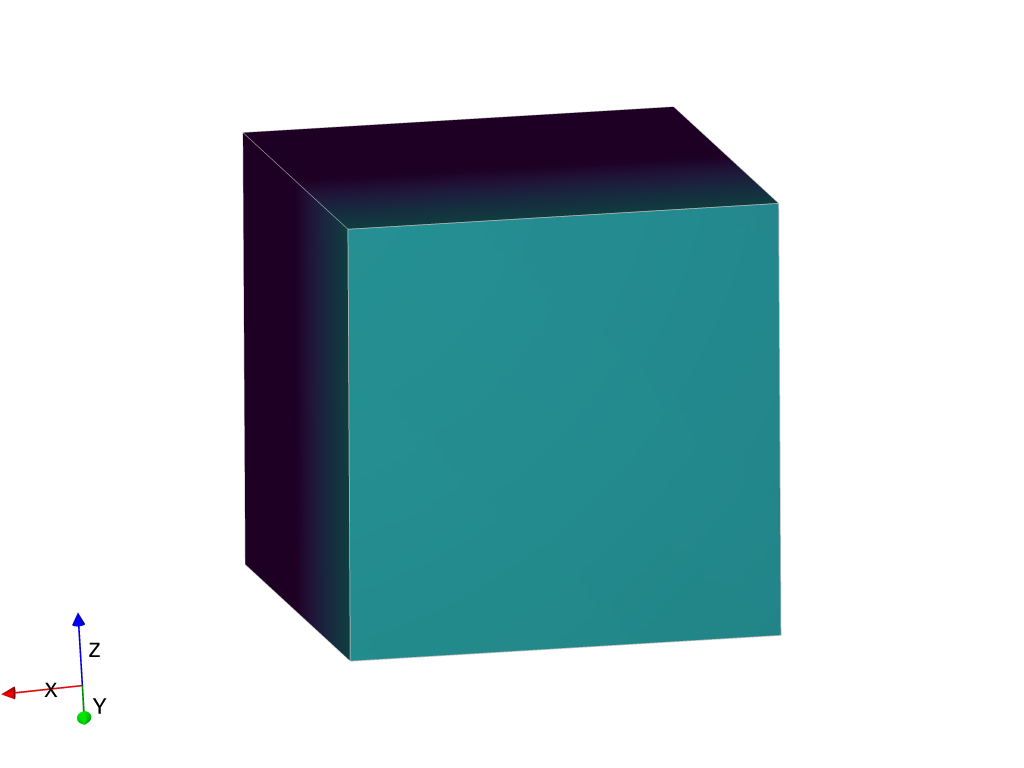

'f1_2.png'

In [14]:
viewer = LavaVuModelViewer(model)
# viewer.add_isosurface(fault['feature'],isovalue=0)
# for i in range(3):
#     viewer.add_data(fault['feature'][i])
# viewer.add_isosurface(fault['feature'][1],nslices=5)
# # viewer.add_isosurface(fault['feature'][2],nslices=5)
# viewer.add_isosurface(strati['feature'],
#                      nslices=5)
viewer.add_scalar_field(fault['feature'][2],cmap='viridis',vmin=.5,vmax=1.5)
# viewer.add_scalar_field(f1_displacement_feature,cmap='rainbow')
viewer.lv.rotate(rotation)
viewer.lv.display()
viewer.lv.image('f1_2.png')

In [15]:
x = np.linspace(-1,1,100)
# plt.plot(x,gxf(x))

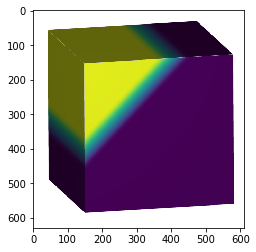

In [16]:
plt.imshow(plt.imread('f1_0.png')[75:705, 200:810,:])


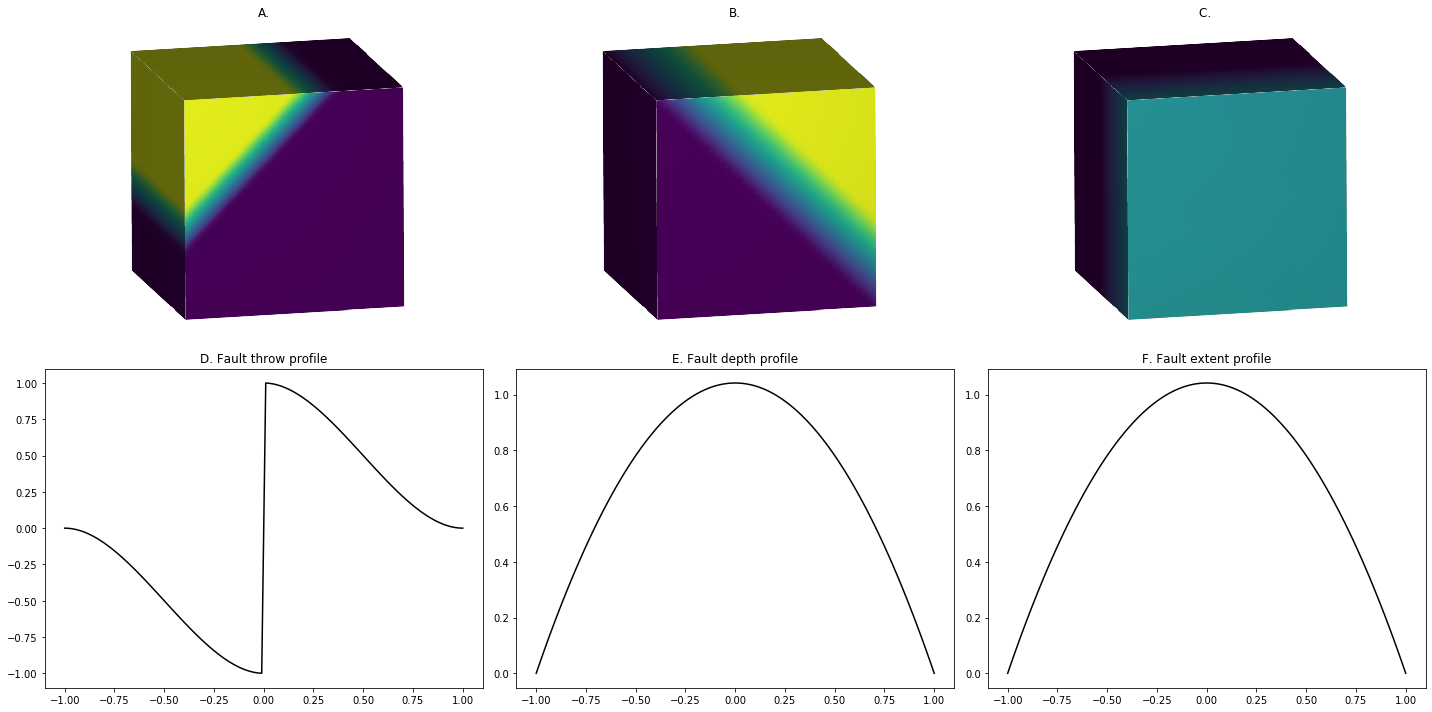

In [17]:
fig, ax = plt.subplots(2,3,figsize=(20,10))
ax[0,0].imshow(plt.imread('f1_0.png')[75:705, 200:810,:])
ax[0,0].set_title('A.')
ax[0,1].imshow(plt.imread('f1_1.png')[75:705, 200:810,:])
ax[0,1].set_title('B.')
ax[0,2].imshow(plt.imread('f1_2.png')[75:705, 200:810,:])

ax[0,2].set_title('C. ')
ax[1,0].plot(x,gxf(x),'k-')#(plt.imread('4.png')[200:565, 178:844,:])
ax[1,0].set_title('D. Fault throw profile')
ax[1,1].plot(x,gyf(x),'k-')#imshow(plt.imread('3.png')[200:565, 178:844,:])
ax[1,1].set_title('E. Fault depth profile')
ax[1,2].plot(x,gzf(x),'k-')#imshow(plt.imread('4.png')[200:565, 178:844,:])
ax[1,2].set_title('F. Fault extent profile')

for i in range(1):
    for j in range(3):
        ax[i,j].axis('off')
plt.tight_layout()

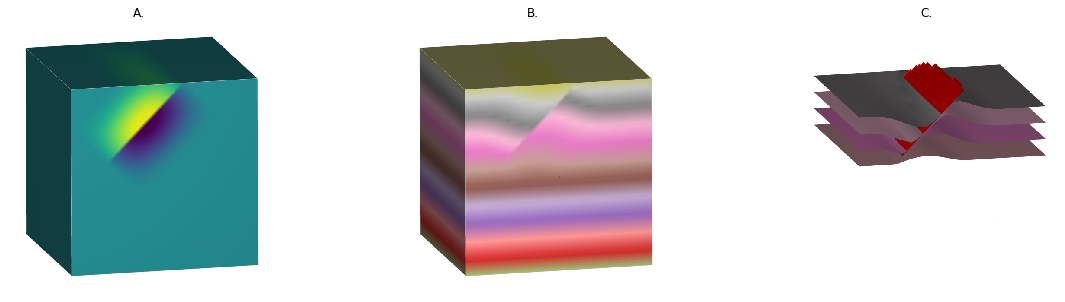

In [23]:
fig, ax = plt.subplots(1,3,figsize=(20,5))
ax[0].imshow(plt.imread(output+'/fault_displacement.png')[75:705, 200:810,:])
ax[0].set_title('A.')
ax[1].imshow(plt.imread(output+'/stratigraphy.png')[75:705, 200:810,:])
ax[1].set_title('B.')
ax[2].imshow(plt.imread(output+'/surfaces.png')[75:705, 200:810,:])
ax[2].set_title('C.')
for i in range(1):
    for j in range(3):
        ax[j].axis('off')